# Мастерская 1  

## Постановка задачи  

Заказчик предоставил данные о стартапах, работавших в период с 1970 по 2018 годы. Необходимо создать модель, которая сможет предсказать, какие из этих стартапов закроются.  

## Цель исследования  
 - Разработать модель машинного обучения для предсказания продолжения деятельности стартапа.   
 - Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).

## Описание данных  

Заказчик предоставил данные в двух файлах: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'  

 - **name** - Название стартапа
 - **category_list** - Список категорий, к которым относится стартап
 - **funding_total_usd** - Общая сумма финансирования в USD
 - **status** - Статус стартапа (закрыт или действующий)
 - **country_code** - Код страны
 - **state_code** - Код штата
 - **region** - Регион
 - **city** - Город
 - **funding_rounds** - Количество раундов финансирования
 - **founded_at** - Дата основания
 - **first_funding_at** - Дата первого раунда финансирования
 - **last_funding_at** - Дата последнего раунда финансирования
 - **closed_at** - Дата закрытия стартапа (если применимо)
 - **lifetime** - Время существования стартапа в днях
  
## План работ  
 - загрузка и ознакомление с данными,
 - предварительная обработка,
 - полноценный разведочный анализ,
 - разработка новых синтетических признаков,
 - проверка на мультиколлинеарность,
 - отбор финального набора обучающих признаков,
 - выбор и обучение моделей,
 - итоговая оценка качества предсказания лучшей модели,
 - анализ важности ее признаков,
 - подготовка отчета по исследованию.

# 1. Импорт библиотек

In [1]:
!pip install pandas -q
!pip install matplotlib -q
!pip install numpy==2.1 -q
!pip install seaborn -q
!pip install scipy -q
!pip install scikit-learn -q
!pip install --upgrade phik -q
!pip install optuna-integration -q
!pip install shap -q

In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats as st
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from optuna.integration import OptunaSearchCV
import optuna.distributions as od
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
import phik
from phik import phik_matrix
from sklearn.feature_selection import SelectKBest, f_classif

# 2. Зададим константы

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# 3. Загрузка и первый анализ данных

In [4]:
df_train = pd.read_csv('datasets\kaggle_startups_train_28062024.csv')
df_test = pd.read_csv('datasets\kaggle_startups_test_28062024.csv')

<>:1: SyntaxWarning: invalid escape sequence '\k'
<>:2: SyntaxWarning: invalid escape sequence '\k'
<>:1: SyntaxWarning: invalid escape sequence '\k'
<>:2: SyntaxWarning: invalid escape sequence '\k'
C:\Users\pavli\AppData\Local\Temp\ipykernel_9836\477130604.py:1: SyntaxWarning: invalid escape sequence '\k'
  df_train = pd.read_csv('datasets\kaggle_startups_train_28062024.csv')
C:\Users\pavli\AppData\Local\Temp\ipykernel_9836\477130604.py:2: SyntaxWarning: invalid escape sequence '\k'
  df_test = pd.read_csv('datasets\kaggle_startups_test_28062024.csv')


In [5]:
display(df_train.head())
display(df_train.describe())
df_train.info()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


,funding_total_usd,funding_rounds
count,4.244700e+04,52516.000000
mean,1.824748e+07,1.740670
std,1.871173e+08,1.374522
min,1.000000e+00,1.000000
25%,3.360275e+05,1.000000
50%,2.000000e+06,1.000000
75%,1.000000e+07,2.000000
max,3.007950e+10,19.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [6]:
display(df_test.head())
display(df_test.describe())
df_test.info()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


,funding_total_usd,funding_rounds,lifetime
count,1.054700e+04,13125.000000,13125.000000
mean,1.654910e+07,1.714438,3097.609524
std,9.217283e+07,1.318800,2128.356554
min,1.000000e+00,1.000000,52.000000
25%,3.200000e+05,1.000000,1726.000000
50%,2.000000e+06,1.000000,2526.000000
75%,1.000000e+07,2.000000,3866.000000
max,4.715000e+09,15.000000,17167.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


**Вывод:**  
Мы вывели информацию и первые пять строк датафреймов и можем сделать вывод, что данные успешно загруженны. Все значения и типы данных в столбцах отображенны корректно, за исключением столбца **closed_at**, с ним мы разберемся в следующем этапе.  

- **df_train** состоит из 52516 записей и 13 столбцов.  
- **df_test** состоит из 13125 записей и 11 столбцов.
  
**В обоих датасетах есть следующие данные:**  
 - **name** - название стартапа  
 - **category_list** - список категорий  
 - **funding_total_usd** - общая сумма финансирования в USD  
 - **country_code** - код страны  
 - **state_code** - код штата  
 - **region** - регион  
 - **city** - город  
 - **funding_rounds** - количество раундов финансирования  
 - **first_funding_at** - дата первого раунда финансирования  
 - **last_funding_at** - дата последнего раунда финансирования  
  
**Остальные данные**:  
  
**df_train**:  
 - **status** - Статус стартапа (закрыт или действующий)  
 - **founded_at** - Дата основания  
 - **closed_at** -  Дата закрытия стартапа (если применимо)  
  
**df_test**:  
 - **lifetime** - Время существования стартапа в днях  

# 4. Предобработка данных

## 4.1 Наименования столбцов  
Все названия столбцов соответствуют правилам и не нуждаются в изменениях.

## 4.2 Пропуски  
При первичном анализе данных были замечены пропущенные значения в данных. Выведем процентное соотношение пропусков для каждого столбца в обоих датасетах.

In [7]:
report = df_train.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df_train.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
closed_at,47599,0.91
funding_total_usd,10069,0.19
state_code,6763,0.13
region,6359,0.12
city,6359,0.12
country_code,5502,0.10
category_list,2465,0.05
name,1,0.00
status,0,0.00
funding_rounds,0,0.00


In [8]:
report = df_test.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df_test.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
funding_total_usd,2578,0.20
state_code,1695,0.13
region,1589,0.12
city,1587,0.12
country_code,1382,0.11
category_list,591,0.05
name,0,0.00
funding_rounds,0,0.00
first_funding_at,0,0.00
last_funding_at,0,0.00


**Вывод:**  

Чтобы обучить модель на тренировочных данных, в них не должно быть пропусков. Поскольку в совокупности доля пропущенных значений высока, то удалять строки с пропусками не подходящяя идея, поэтому заменим эти пропущенные значения. В столбце **closed_at** в **df_train** в качестве замены будем использовать дату выгрузки данных - "2018-01-01". Для заполнения пропусков в **funding_total_usd** будем использовать медианное значение сгруппировав по столбцу **funding_rounds**.

In [9]:
fillna_train = {
    'closed_at': '2018-01-01',
    'state_code': 'no_state_code',
    'region': 'no_region',
    'city': 'no_city',
    'country_code': 'no_country_code',
    'category_list': 'no_category',
    'name': 'no_name'
}

fillna_test = {
    'state_code': 'no_state_code',
    'region': 'no_region',
    'city': 'no_city',
    'country_code': 'no_country_code',
    'category_list': 'no_category_'
}

In [10]:
df_train.fillna(value=fillna_train, inplace=True)
df_test.fillna(value=fillna_test, inplace=True)

In [11]:
display(df_train.info())
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52516 non-null  object 
 1   category_list      52516 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       52516 non-null  object 
 5   state_code         52516 non-null  object 
 6   region             52516 non-null  object 
 7   city               52516 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          52516 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      13125 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       13125 non-null  object 
 4   state_code         13125 non-null  object 
 5   region             13125 non-null  object 
 6   city               13125 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [12]:
df_train['funding_total_usd'].fillna(value=(df_train.groupby('funding_rounds')['funding_total_usd'].median()))

0          828626.0
1        42935019.0
2        35456381.0
3        22250000.0
4        15000000.0
            ...    
52511           NaN
52512      500000.0
52513       50000.0
52514    13000000.0
52515      270820.0
Name: funding_total_usd, Length: 52516, dtype: float64

In [13]:
for df in df_train['funding_rounds'].unique():
        df_train.loc[(df_train['funding_rounds'] == df) & (df_train['funding_total_usd'].isna()), 'funding_total_usd'] = \
        df_train.loc[(df_train['funding_rounds'] == df), 'funding_total_usd'].median()

for df in df_test['funding_rounds'].unique():
        df_test.loc[(df_test['funding_rounds'] == df) & (df_test['funding_total_usd'].isna()), 'funding_total_usd'] = \
        df_test.loc[(df_test['funding_rounds'] == df), 'funding_total_usd'].median()

In [14]:
display(df_train.info())
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52516 non-null  object 
 1   category_list      52516 non-null  object 
 2   funding_total_usd  52516 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       52516 non-null  object 
 5   state_code         52516 non-null  object 
 6   region             52516 non-null  object 
 7   city               52516 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          52516 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      13125 non-null  object 
 2   funding_total_usd  13125 non-null  float64
 3   country_code       13125 non-null  object 
 4   state_code         13125 non-null  object 
 5   region             13125 non-null  object 
 6   city               13125 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


**Вывод:**  

Теперь пропуски в обоих датафреймах заполнены, остался только столбец **lifetime**, но с ним мы разберемся позже.

## 4.3 Типы данных

Заменим типы данных в столбцах **first_funding_at**, **last_funding_at**, **founded_at** и **closed_at** на datetime64.

In [15]:
df_train['first_funding_at'] = pd.to_datetime(df_train['first_funding_at'], format='%Y-%m-%d')
df_train['last_funding_at'] = pd.to_datetime(df_train['last_funding_at'], format='%Y-%m-%d')
df_train['founded_at'] = pd.to_datetime(df_train['founded_at'], format='%Y-%m-%d')
df_train['closed_at'] = pd.to_datetime(df_train['closed_at'], format='%Y-%m-%d')

In [16]:
df_test['first_funding_at'] = pd.to_datetime(df_test['first_funding_at'], format='%Y-%m-%d')
df_test['last_funding_at'] = pd.to_datetime(df_test['last_funding_at'], format='%Y-%m-%d')

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52516 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  52516 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          52516 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  13125 non-null  float64       
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


**Вывод:**  

Теперь типы данных указаны верно.

## 4.4 Явные дубликаты

In [19]:
print('Количество явных дубликатов в df_train:', df_train.duplicated().sum())
print('Количество явных дубликатов в df_test:', df_test.duplicated().sum())

Количество явных дубликатов в df_train: 0
Количество явных дубликатов в df_test: 0


Явные дубликаты отсутствуют

## 4.5 Неявные дубликаты

In [20]:
print('Количество и доля уникальных значений df_train:')
display(pd.DataFrame({
    'Название колонки': df_train.columns,
    'Кол-во уникальных значений': [df_train[col].nunique(dropna=True) for col in df_train.columns],
    'Доля уникальных значений, %': [round(df_train[col].nunique(dropna=True) / df_train.shape[0] * 100, 2) for col in df_train.columns]
}))

Количество и доля уникальных значений df_train:


,Название колонки,Кол-во уникальных значений,"Доля уникальных значений, %"
0,name,52516,100.00
1,category_list,22106,42.09
2,funding_total_usd,15555,29.62
3,status,2,0.00
4,country_code,135,0.26
5,state_code,301,0.57
6,region,1037,1.97
7,city,4478,8.53
8,funding_rounds,19,0.04
9,founded_at,5402,10.29


In [21]:
print('Количество и доля уникальных значений df_test:')
display(pd.DataFrame({
    'Название колонки': df_test.columns,
    'Кол-во уникальных значений': [df_test[col].nunique(dropna=True) for col in df_test.columns],
    'Доля уникальных значений, %': [round(df_test[col].nunique(dropna=True) / df_test.shape[0] * 100, 2) for col in df_test.columns]
}))

Количество и доля уникальных значений df_test:


,Название колонки,Кол-во уникальных значений,"Доля уникальных значений, %"
0,name,13125,100.00
1,category_list,6207,47.29
2,funding_total_usd,4553,34.69
3,country_code,97,0.74
4,state_code,236,1.80
5,region,689,5.25
6,city,2118,16.14
7,funding_rounds,15,0.11
8,first_funding_at,3299,25.14
9,last_funding_at,3021,23.02


**Вывод:**  

В обоих датафреймах много уникальных категориальных данных. С ними будет трудно провести визуальный анализ, поэтому проведем анализ только тех признаков, количество уникальных значений в которых меньше всего.

In [22]:
print('Уникальные значения в столбце "status" датафрема df_train')
print(df_train['status'].unique())
print()

print('Уникальные значения в столбце "country_code" датафрема df_train')
print(df_train['country_code'].unique())
print()

print('Уникальные значения в столбце "country_code" датафрема df_test')
print(df_test['country_code'].unique())
print()

Уникальные значения в столбце "status" датафрема df_train
['operating' 'closed']

Уникальные значения в столбце "country_code" датафрема df_train
['CHE' 'USA' 'no_country_code' 'GBR' 'RUS' 'ESP' 'FRA' 'SWE' 'IND' 'KOR'
 'AUS' 'TWN' 'CHN' 'HUN' 'CAN' 'FIN' 'BRA' 'EGY' 'PRT' 'ISR' 'CHL' 'SVK'
 'NLD' 'ARG' 'ARE' 'JPN' 'IRL' 'DEU' 'LBN' 'EST' 'IDN' 'BEL' 'MEX' 'DNK'
 'ITA' 'GRC' 'ROM' 'TUR' 'SGP' 'SAU' 'MYS' 'NGA' 'QAT' 'VNM' 'BGR' 'GHA'
 'UGA' 'JOR' 'AUT' 'PAK' 'NZL' 'HKG' 'ZAF' 'LVA' 'NOR' 'HRV' 'VEN' 'PER'
 'LUX' 'SVN' 'POL' 'PHL' 'NIC' 'CZE' 'ISL' 'PAN' 'URY' 'BGD' 'MCO' 'GTM'
 'THA' 'TTO' 'UKR' 'KEN' 'CRI' 'DZA' 'LTU' 'CYM' 'MUS' 'BLR' 'SLV' 'COL'
 'MLT' 'PSE' 'BLZ' 'CYP' 'MMR' 'MKD' 'KHM' 'GIB' 'SRB' 'DOM' 'BWA' 'BLM'
 'PRY' 'BMU' 'TAN' 'LIE' 'GRD' 'UZB' 'GEO' 'SEN' 'ALB' 'ECU' 'MOZ' 'LKA'
 'LAO' 'TUN' 'HND' 'ZWE' 'BAH' 'MDA' 'MAF' 'BHR' 'AZE' 'MAR' 'KWT' 'IRN'
 'GGY' 'KNA' 'PRI' 'OMN' 'KAZ' 'JAM' 'NPL' 'ARM' 'TGO' 'RWA' 'BRN' 'JEY'
 'SOM' 'CMR' 'MNE' 'SYC' 'ZMB']

Уникальные значени

**Вывод:**  

Неявные дубликаты в данных признаках не найдены.

## 4.6 Новые столбцы

### 4.6.1 lifetime 
  
Добавим столбец **lifetime** в таблицу df_train как разницу между **closed_at** и **founded_at**.

In [23]:
df_train['lifetime'] = (df_train['closed_at'] - df_train['founded_at']).dt.days
df_train['lifetime']

0        2998
1        4748
2        4383
3        5114
4        2791
         ... 
52511    2192
52512    1590
52513    2741
52514    7336
52515    1969
Name: lifetime, Length: 52516, dtype: int64

### 4.6.2 lifetime_category  
  
Создадим категории для колонки **lifetime**. Известно, что в мире в среднем около 50% стартапов работают до 5 лет, а 30% доживают и до 10 лет.

In [24]:
bins = [0, 365, 365*2, 365*5, 365*10, df_train['lifetime'].max()]
labels = ['до 1 года', '1-2 лет', '2-5 лет', '5-10 лет', 'от 10 лет']

df_train['lifetime_category'] = pd.cut(df_train['lifetime'], bins=bins, labels=labels)

bins2 = [0, 365, 365*2, 365*5, 365*10, df_test['lifetime'].max()]

df_test['lifetime_category'] = pd.cut(df_test['lifetime'], bins=bins2, labels=labels)

### 4.6.3 category_list  

В обоих датафреймах category_list имеет высокий процент уникальных значений, 42% для df_train и 47% для df_test. Вероятно, что при обучении модели данный признак будет иметь высокое влияние. Большое количество уникальных значений в данном столбце объясняется тем, что у некоторых стартапов указано несколько категорий с разделителем "|". Обычно на первом месте указывают основную категорию, поэтому создадим столбец **first_category** указав в нем основную категорию для каждого стартапа.

In [25]:
df_train['category_list'].sample(30)

2580                                       Food Processing
33069                                        Biotechnology
36889                                          Advertising
3437                   Enterprise Software|Risk Management
7608                                              Software
25705    Audio|Hardware + Software|Internet Radio Marke...
30728                                          no_category
28205    Crowdsourcing|Digital Entertainment|Families|P...
32462    Crowdsourcing|Digital Media|Internet|Social Media
41796    Billing|E-Commerce|Payments|Sales and Marketin...
49348                                          no_category
3100                                               Medical
2872                                           no_category
12999                                             Software
28354                 Payments|Rental Housing|Social Media
52231    Android|Internet Marketing|iOS|Mobile|Mobile C...
32107                                        Biotechnolo

In [26]:
df_train['first_category'] = df_train['category_list'].str.split('|').str[0].str.strip()
df_test['first_category'] = df_test['category_list'].str.split('|').str[0].str.strip()
display(df_train.head(10))
df_test.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,lifetime_category,first_category
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,2998,5-10 лет,Online Reservations
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748,от 10 лет,Manufacturing
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383,от 10 лет,Biotechnology
3,Sancilio and Company,Health Care,22250000.0,operating,no_country_code,no_state_code,no_region,no_city,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114,от 10 лет,Health Care
4,WireTough Cylinders,Manufacturing,860000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,2791,5-10 лет,Manufacturing
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,2018-01-01,2452,5-10 лет,Mobile
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,2018-01-01,6575,от 10 лет,Analytics
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,2018-01-01,4748,от 10 лет,Software
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,2018-01-01,5479,от 10 лет,Biotechnology
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,2018-01-01,2922,5-10 лет,Semiconductors


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,lifetime_category,first_category
0,Crystalsol,Clean Technology,2.819200e+06,NIC,17,no_region,no_city,1,2009-07-01,2009-07-01,3501,5-10 лет,Clean Technology
1,JBI Fish & Wings,Hospitality,8.841858e+05,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,5-10 лет,Hospitality
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,2-5 лет,Finance
3,Imagine Communications,Software|Video|Video Streaming,3.470000e+07,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,от 10 лет,Software
4,DNA13,Software,4.530000e+06,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,от 10 лет,Software
5,Quickfire Games,Design|Entertainment|Games,1.600000e+05,no_country_code,no_state_code,no_region,no_city,2,2013-09-18,2014-09-18,1583,2-5 лет,Design
6,Sente Inc.,Biotechnology,2.684200e+07,USA,CA,San Diego,Encinitas,5,2009-01-31,2014-06-02,4018,от 10 лет,Biotechnology
7,Triosyn,Health Care|Medical|Therapeutics,4.000000e+06,no_country_code,no_state_code,no_region,no_city,1,2003-06-02,2003-06-02,5576,от 10 лет,Health Care
8,Urgent.ly,Software,8.710000e+06,USA,VA,"Washington, D.C.",Sterling,3,2014-04-17,2015-09-29,1826,5-10 лет,Software
9,Map Decisions,Software,1.320000e+04,USA,PA,Allentown,Bethlehem,1,2013-08-09,2013-08-09,2057,5-10 лет,Software


Еще раз проверим долю уникальных значений в обоих таблицах.

In [27]:
print('Количество и доля уникальных значений df_train:')
display(pd.DataFrame({
    'Название колонки': df_train.columns,
    'Кол-во уникальных значений': [df_train[col].nunique(dropna=True) for col in df_train.columns],
    'Доля уникальных значений, %': [round(df_train[col].nunique(dropna=True) / df_train.shape[0] * 100, 2) for col in df_train.columns]
}))

Количество и доля уникальных значений df_train:


,Название колонки,Кол-во уникальных значений,"Доля уникальных значений, %"
0,name,52516,100.00
1,category_list,22106,42.09
2,funding_total_usd,15555,29.62
3,status,2,0.00
4,country_code,135,0.26
5,state_code,301,0.57
6,region,1037,1.97
7,city,4478,8.53
8,funding_rounds,19,0.04
9,founded_at,5402,10.29


In [28]:
print('Количество и доля уникальных значений df_test:')
display(pd.DataFrame({
    'Название колонки': df_test.columns,
    'Кол-во уникальных значений': [df_test[col].nunique(dropna=True) for col in df_test.columns],
    'Доля уникальных значений, %': [round(df_test[col].nunique(dropna=True) / df_test.shape[0] * 100, 2) for col in df_test.columns]
}))

Количество и доля уникальных значений df_test:


,Название колонки,Кол-во уникальных значений,"Доля уникальных значений, %"
0,name,13125,100.00
1,category_list,6207,47.29
2,funding_total_usd,4553,34.69
3,country_code,97,0.74
4,state_code,236,1.80
5,region,689,5.25
6,city,2118,16.14
7,funding_rounds,15,0.11
8,first_funding_at,3299,25.14
9,last_funding_at,3021,23.02


**Вывод:**  

Теперь процент уникальных значений категорий снизился до 1% в df_train и до 4% в df_test.

## 4.7 Вывод по предобработке данных  

В ходе предобработки было сделано:  
  
 - Заполнены пропуски в **df_train** и **df_test**  
 - Изменены типы данных для **founded_at**, **first_funding_at**, **last_funding_at** и **closed_at** на **datetime64**  
 - Создан **lifetime** для **df_train**  
 - Выделены основные категории деятельности стартапов  
  
Пропуски и дубликаты отсутствуют и данные готовы к исследовательскому анализу.

# 5. Исследовательский анализ данных

Для начала выведем топ-20 самый частых значений в категориальных признаках.

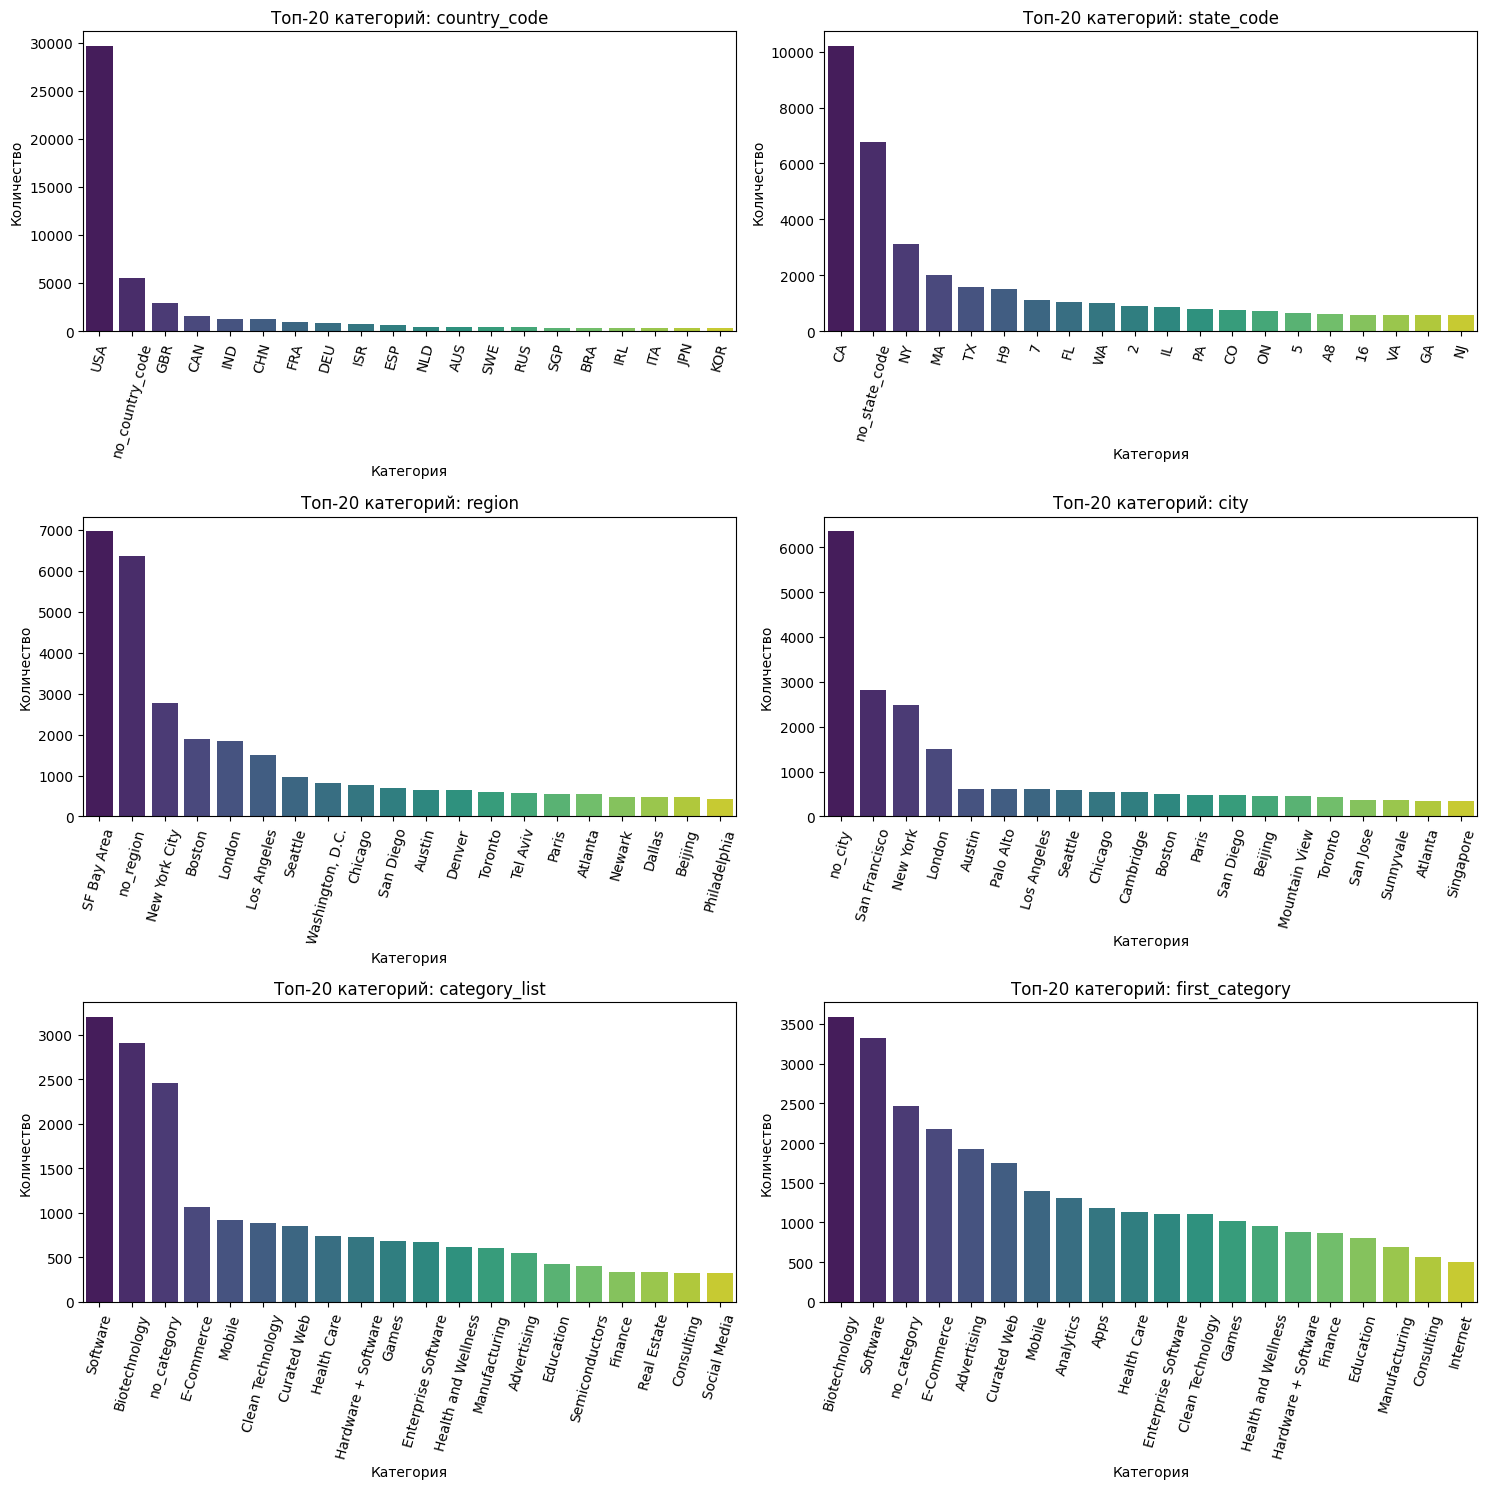

In [29]:
category_columns = ['country_code', 'state_code', 'region', 'city', 'category_list', 'first_category']

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
for i, col in enumerate(category_columns):
    ax = axes[i]

    top_category = df_train[col].value_counts().head(20)

    sns.barplot(x=top_category.index, y=top_category.values, hue=top_category.index, ax=ax, palette='viridis')
    ax.set_title(f'Топ-20 категорий: {col}')
    ax.set_xlabel('Категория')
    ax.set_ylabel('Количество')
    ax.tick_params(axis='x', rotation=75)

plt.tight_layout()
plt.show()

**Вывод:**  

1. **country_code:**
 - **USA** - Больше всего стартапов с кодом страны **USA**  
 - **no_country_code** - Примерно у 5тыс. стартапов не указан код страны  
 - **GBR** - Около 3тыс. стартапов имеют код страны **GBR**  
  
2. **state_code:**
 - **CA** - Чуть больше 10тыс. стартапов с данным кодом  
 - **no_state_code** - Почти 7тыс. стартапов без **state_code**  
 - **NY** - Около 4тыс. стартапов имеют код **NY**  
  
3. **region:**  
 - **SF Bay Area** - 7тыс. стартапов находятся в данном регионе
 - **no_region** - Для 6.4тыс. стартапов не указан регион
 - **New York City** - Почти 3тыс. стартапов находятся в этом регионе
  
4. **city:**  
 - **no_city** - Для более чем 6тыс. стартапов не указан город  
 - **San Francisco** - 3тыс. стартапов в **San Francisco**  
 - **New York** - 2.5тыс. стартапов в **New York**  
  
Глядя на графики **category_list** и **first_category** особо большой разницы нет.  

 - В **first_category** чуть больше 3.5тыс. стартапов с категорией **Biotechnology** и чуть больше 3тыс. стартапов с категориец деятельности **Software**, так же 2.5тыс. стартапов без категории.

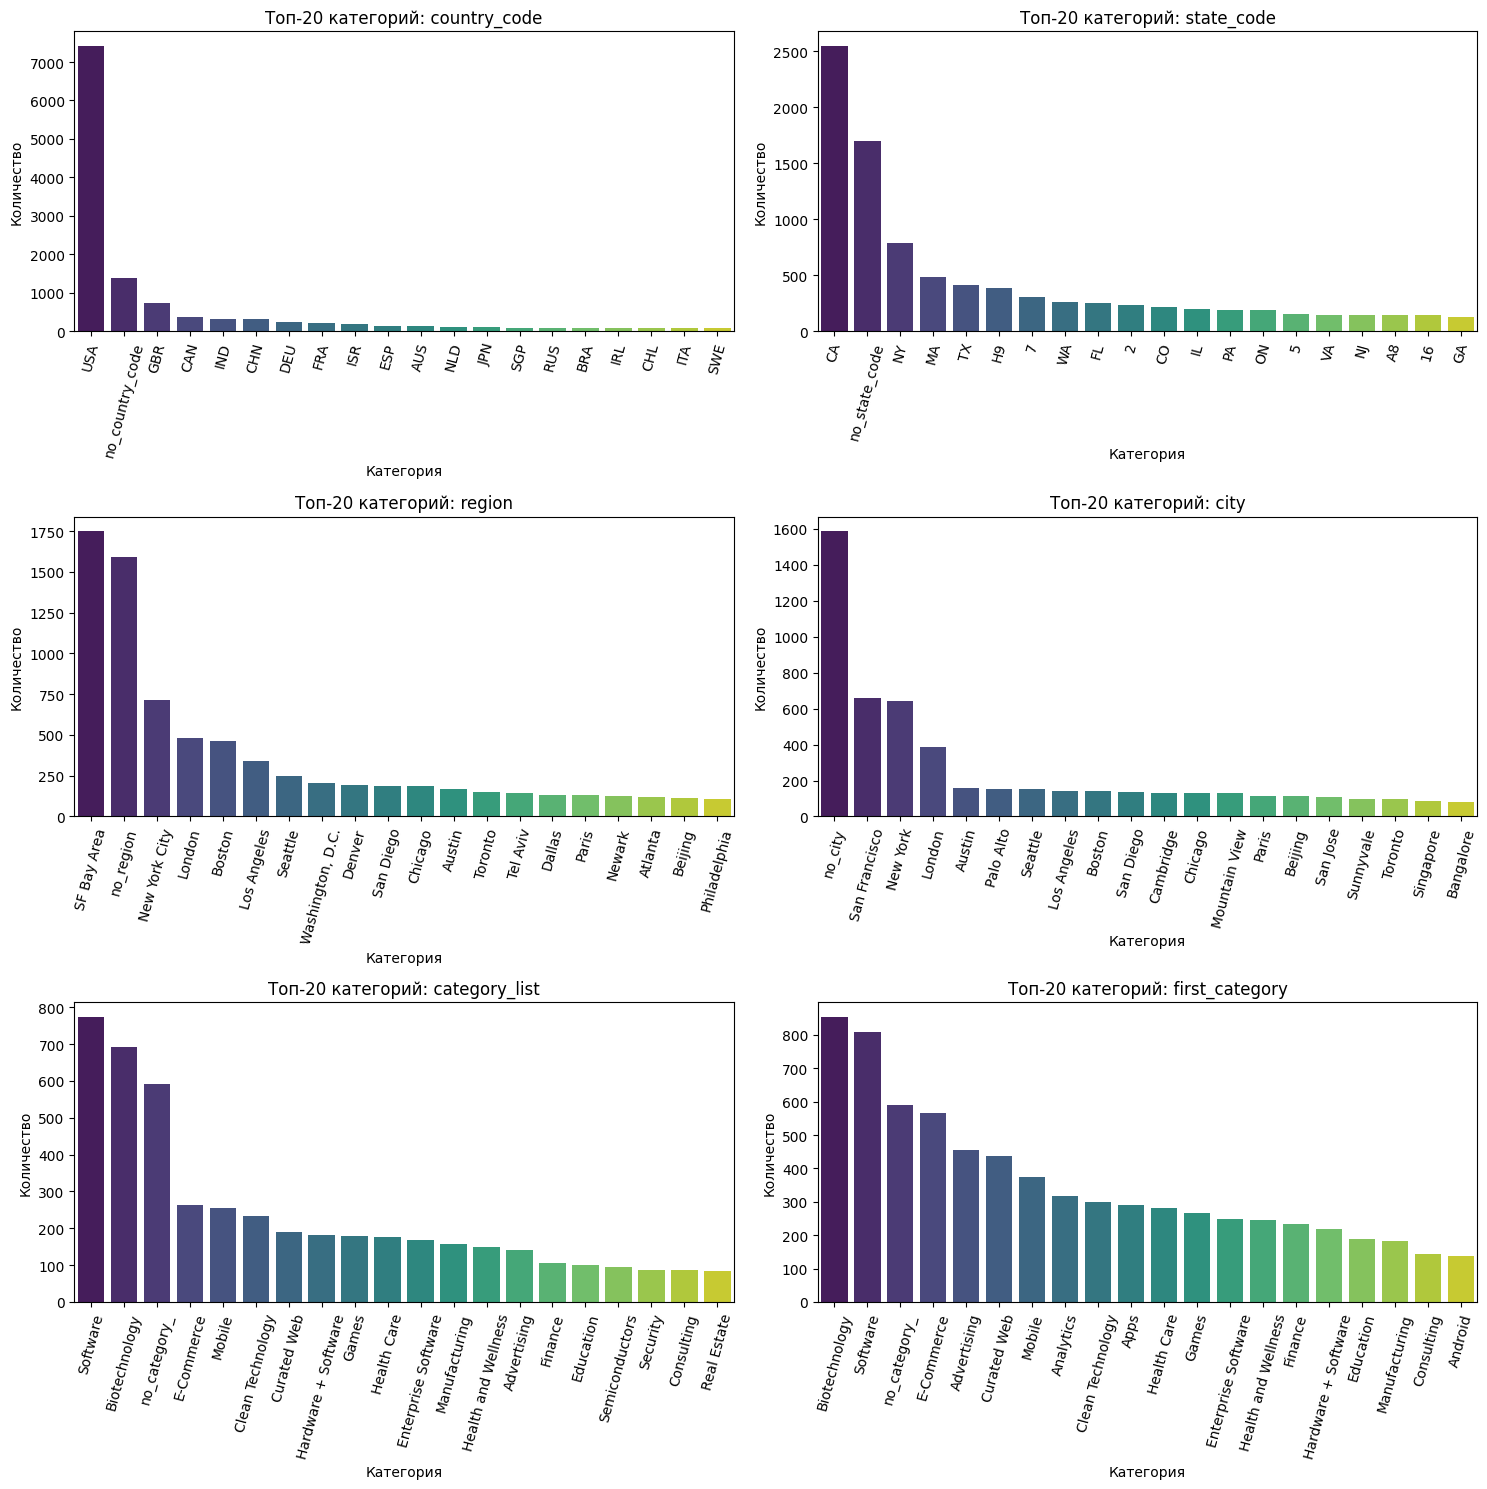

In [30]:
category_columns_test = ['country_code', 'state_code', 'region', 'city', 'category_list', 'first_category']

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
for i, col in enumerate(category_columns_test):
    ax = axes[i]

    top_category = df_test[col].value_counts().head(20)

    sns.barplot(x=top_category.index, y=top_category.values, hue=top_category.index, ax=ax, palette='viridis')
    ax.set_title(f'Топ-20 категорий: {col}')
    ax.set_xlabel('Категория')
    ax.set_ylabel('Количество')
    ax.tick_params(axis='x', rotation=75)

plt.tight_layout()
plt.show()

В **df_test** ситуция точно такая же, на первых местах теже значения.

### 5.1 Выбросы **funding_total_usd**, **funding_rounds**, **lifetime**

### 5.1.1 funding_total_usd

In [31]:
def df_visualization(df):
    for column in df.columns:
        column_type = df[column].dtype
        
        if column_type in ['int64', 'float64']:
            fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 4))
            axes = axes.ravel()
            sns.histplot(data = df[column], kde=True, bins = 30, ax=axes[0])
            axes[0].set_title(column)
            mean = df[column].mean()
            axes[0].axvline(mean, color = 'red', linestyle = '-', label = f'Mean: {mean:.2f}' )
            median = df[column].median()
            axes[0].axvline(median, color = 'yellow', linestyle = '--', label = f'Median: {median:.2f}')
            axes[0].legend()
            axes[0].legend(loc = 'upper right')
            
            sns.boxplot(x=df[column], ax=axes[1])
            axes[1].set_title(f'{column}')
            axes[1].set_xlabel(column)
            plt.show()

In [32]:
df_train[['funding_total_usd', 'funding_rounds', 'lifetime']].describe()

,funding_total_usd,funding_rounds,lifetime
count,5.251600e+04,52516.000000,52516.000000
mean,1.497812e+07,1.740670,3140.828129
std,1.683613e+08,1.374522,2147.821070
min,1.000000e+00,1.000000,19.000000
25%,5.297212e+05,1.000000,1739.000000
50%,1.021239e+06,1.000000,2557.000000
75%,7.000000e+06,2.000000,4018.000000
max,3.007950e+10,19.000000,17378.000000


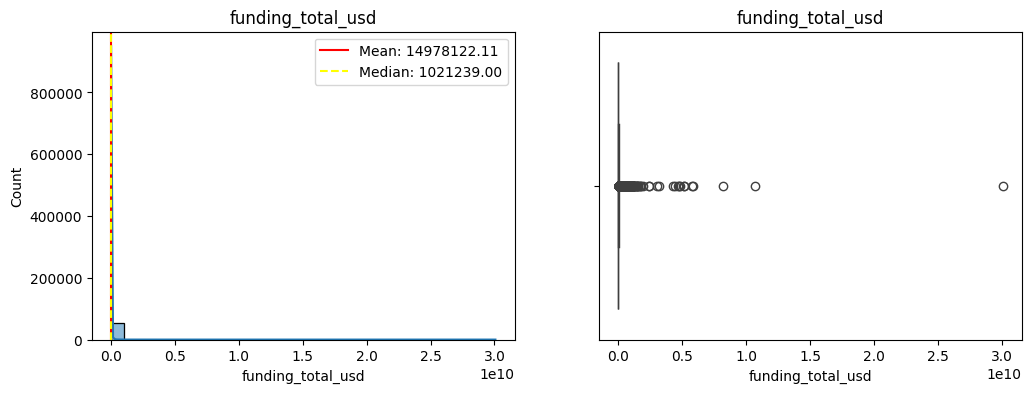

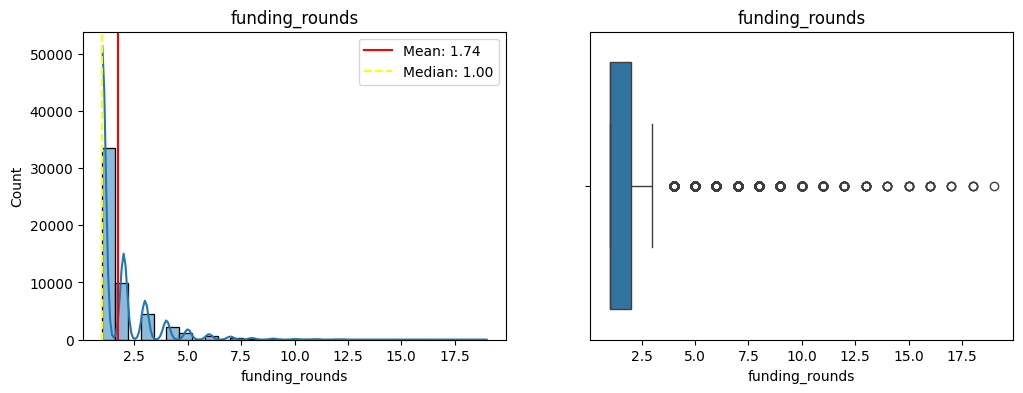

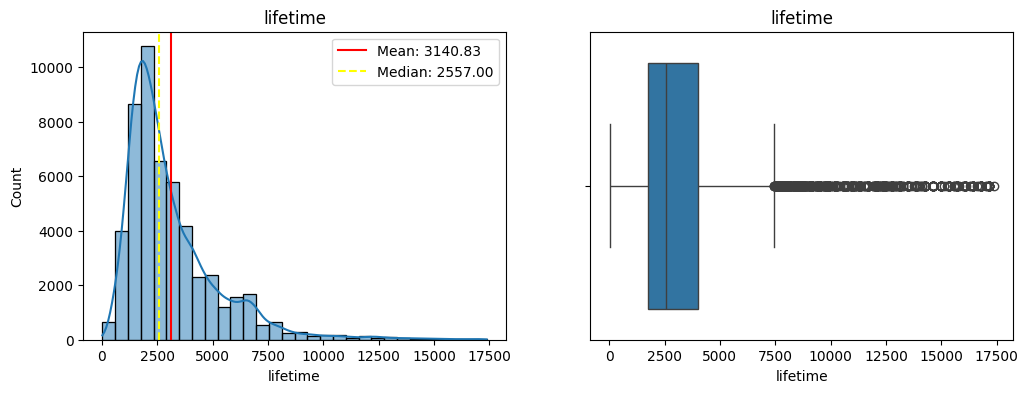

In [33]:
df_visualization(df_train)

**Вывод:**  
  
Глядя на графики и результат вывода **describe()** видно, что Q1 и Q3 для funding_total_usd равны 529тыс. и 7млн. соответственно, максимальное значение составляет 30млрд.. Выведем еще 1 график для **funding_total_usd** с ограничением по оси x до 200млн..

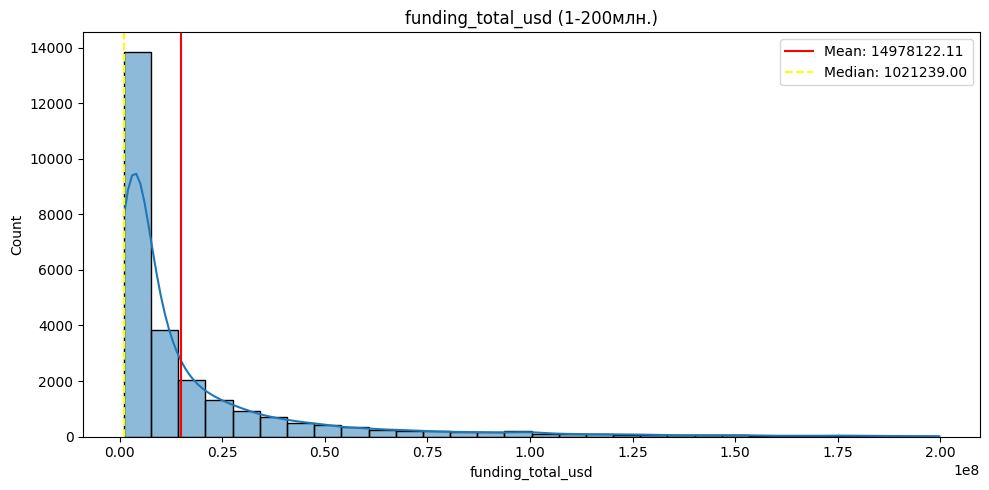

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(df_train.query('1000000 < funding_total_usd < 200000000')['funding_total_usd'], bins=30, kde=True, ax=ax)
ax.set_title('funding_total_usd (1-200млн.)')
mean = df_train['funding_total_usd'].mean()
ax.axvline(mean, color = 'red', linestyle = '-', label = f'Mean: {mean:.2f}' )
median = df_train['funding_total_usd'].median()
ax.axvline(median, color = 'yellow', linestyle = '--', label = f'Median: {median:.2f}')
ax.legend()
ax.legend(loc = 'upper right')
plt.tight_layout()

**Вывод:**  

Глядя на график можно сделать вывод, что после 100млн. уже идут выбросы и их можно отсечь.

In [35]:
df_train_shape = df_train.shape[0]
df_train = df_train.query('funding_total_usd < 100000000')

In [36]:
print(f'Процент данных после удаления выбросов: {round(df_train.shape[0] / df_train_shape * 100, 2)}%')

Процент данных после удаления выбросов: 97.51%


### 5.1.2 funding_rounds

По графикам **funding_rounds** тоже видно, что после значения выше 6 уже редко встречаются, поэтому так же удалим данные с этими значениями.

In [37]:
df_train = df_train.query('funding_rounds < 7')
print(f'Процент данных после удаления выбросов: {round(df_train.shape[0] / df_train_shape * 100, 2)}%')

Процент данных после удаления выбросов: 96.48%


### 5.1.3 lifetime

На графике **lifetime** выбросами можно считать значения больше 12500.

In [38]:
df_train = df_train.query('lifetime < 12500')
print(f'Процент данных после удаления выбросов: {round(df_train.shape[0] / df_train_shape * 100, 2)}%')

Процент данных после удаления выбросов: 95.91%


**Вывод:**  

Мы вывели графики для численных и категориальных признаков, проанализировали их и избавились от выбросов. Процент удаленных данных составляет 4.09%.  
Далее проведем корреляционный анализ признаков.

## Корреляционный анализ

Уберем лишние признаки и построим матрицу корреляции.

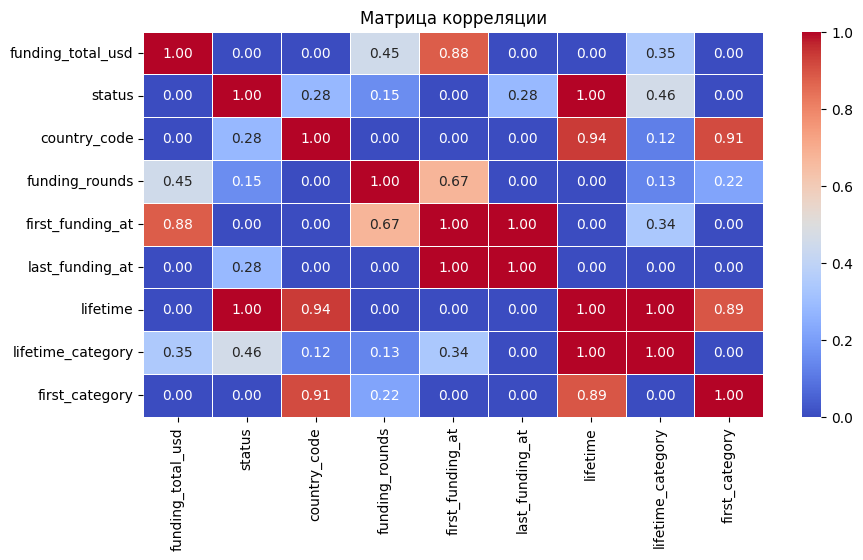

In [39]:
interval_columns = ['funding_total_usd']
df_correlation = (df_train.drop([
    'name', 
    'category_list', 
    'state_code', 
    'region', 
    'city', 
    'founded_at',
    'closed_at'], axis=1).sample(1000).phik_matrix(interval_cols=interval_columns))
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(df_correlation, 
            annot=True,
            cmap="coolwarm",
            linewidths=0.5,
            fmt=".2f",
            vmin=0, 
            vmax=1)
plt.title("Матрица корреляции")
plt.show()

**Вывод:**  

Глядя на матрицу корреляции видно, что между целевым признаком **status** и признаком **lifetime** присутствует мультиколлинеарность и видна средняя зависимость целевого признака с признаком **lifetime_category**(0.47). Так же видна высокая корреляция между признаками:  
 - **lifetime** - **country_code**(0.97),   
 - **lifetime** - **lifetime_category**(1.00),  
 - **lifetime** - **first_category**(0.93),   
 - **country_code** - **first_category**(0.83),  
 - **lifetime_category** - **first_category**(0.64),  
 - **funding_rounds** - **first_funding_at**(0.77).

Попробуем вывести матрицы корреляции для обоих значений признака **status** по отдельности.

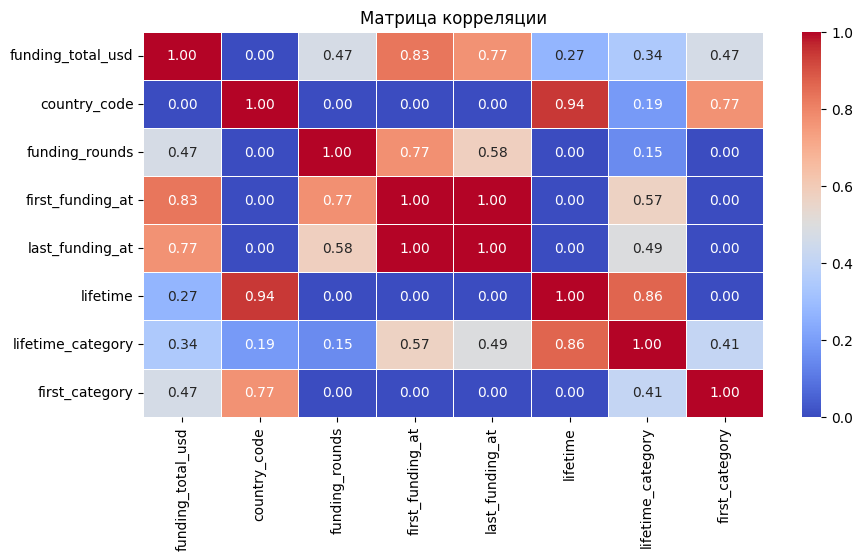

In [40]:
interval_columns = ['funding_total_usd']
df_correlation = (df_train.query('status == "operating"').drop([
    'name', 
    'category_list', 
    'status',
    'state_code', 
    'region', 
    'city', 
    'founded_at',
    'closed_at'], axis=1).sample(1000).phik_matrix(interval_cols=interval_columns))
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(df_correlation, 
            annot=True,
            cmap="coolwarm",
            linewidths=0.5,
            fmt=".2f",
            vmin=0, 
            vmax=1)
plt.title("Матрица корреляции")
plt.show()

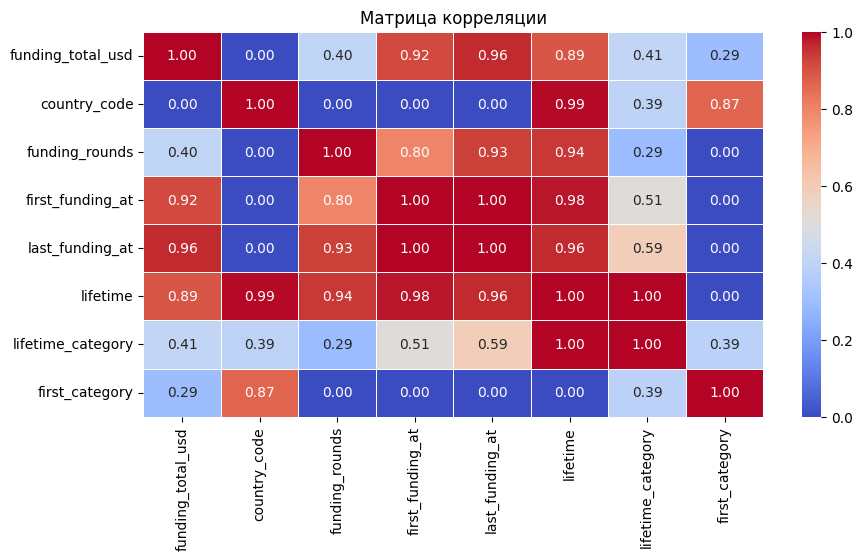

In [41]:
interval_columns = ['funding_total_usd']
df_correlation = (df_train.query('status == "closed"').drop([
    'name', 
    'category_list',
    'status',
    'state_code', 
    'region', 
    'city', 
    'founded_at',  
    'closed_at'], axis=1).sample(1000).phik_matrix(interval_cols=interval_columns))
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(df_correlation, 
            annot=True,
            cmap="coolwarm",
            linewidths=0.5,
            fmt=".2f",
            vmin=0, 
            vmax=1)
plt.title("Матрица корреляции")
plt.show()

**Вывод:**  

Целевой признак **status = operating**:  
  
 - **lifetime** - **first_funding_at**(0.99),
 - **lifetime** - **last_funding_at**(0.99),
 - **lifetime** - **lifetime_category**(0.87),
 - **lifetime** - **first_category**(0.96),
 - **first_category** - **country_code**(0.89),
 - **first_category** - **first_funding_at**(0.82).

Целевой признак **status = closed**:  
  
 - **lifetime** - **funding_rounds**(0.97),
 - **lifetime** - **first_funding_at**(1.00),
 - **lifetime** - **last_funding_at**(0.99),
 - **lifetime** - **lifetime_category**(1.00),
 - **lifetime** - **first_category**(0.99),
 - **country_code** - **last_funding_at**(0.81),
 - **funding_rounds** - **first_funding_at**(0.91),
 - **funding_rounds** - **last_funding_at**(0.77).

Дополнительно построим **histplot** для признаков **status** и **lifetime**.

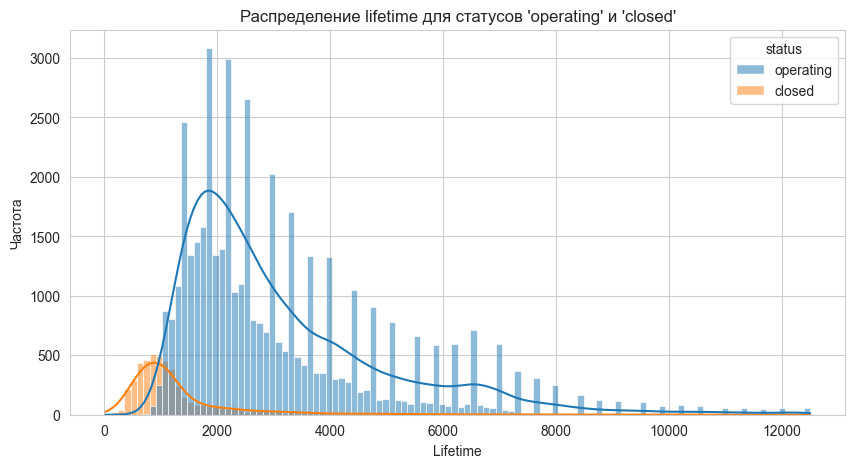

In [42]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))
sns.histplot(
    data=df_train.query('lifetime < 12500')[['status', 'lifetime']],
    x='lifetime', hue='status', kde=True
)
plt.title("Распределение lifetime для статусов 'operating' и 'closed'")
plt.xlabel("Lifetime")
plt.ylabel("Частота")
plt.show()

**Вывод:**  

По графику видно, что пик закрытых стартапов(**closed**) находится в районе 1тыс. дней, а у действующих стартапов(**operating**) около 2тыс. дней.

## Вывод по исследовательскому анализу   
  
**В ходе исследовательского анализу было выполнено:**  
1. Мы вывели топ-20 самый частых значений в категориальных признаках.  
2. Избавились от выбросов в **funding_total_usd**, **funding_rounds** и **lifetime**.  
3. Провели корреляционный анализ.  
4. Так же вывели матрицы корреляции разделив данные на статусы **operating** и **closed**.  
5. Дополнительно вывели гистограмму распределения для целевого признака **status** и признака **lifetime**.


**Выявили, что:**  
- Целевой признак **status** имеет дисбаланс, примерно 90%-operating и 10%-closed.  
- Так же на графике с **funding_total_usd** было заметно смещение вызванное выбросами.  
- Больше всего стартапов с кодом страны **USA**(30тыс.).  
- Примерно у 5тыс. стартапов не указан код страны.  
- Чуть больше 10тыс. стартапов имеют **state_code** - **CA**.   
- Почти 7тыс. стартапов без **state_code**.
- 7тыс. стартапов находятся в регионе **SF Bay Area**.  
- Для 6.4тыс. стартапов не указан регион.  
- Для более чем 6тыс. стартапов не указан город.    
- 3тыс. стартапов в **San Francisco**.  
- Между целевым признаком **status** и признаком **lifetime** присутствует мультиколлинеарность.  
- Признак **lifetime** коррелирует с признаками **country_code**(0.97), **lifetime_category**(1.00) и **first_category**(0.93).  
- Признак **country_code** коррелирует с признаком **first_category**(0.83).  
- Закрытые стартапы зачастую имеют низкое количество дней(**lifetime**).  

# 6. Подготовка данных

In [43]:
X = df_train.drop([
    'name',
    'category_list',
    'status',
    'country_code',
    'state_code',
    'region',
    'city',
    'founded_at',
    'closed_at',
], axis=1)
y = df_train['status']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE
)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(37777, 7) (37777,)
(12593, 7) (12593,)


In [44]:
num_col_names = X.select_dtypes(include='number').columns.tolist()
cat_col_names = X.select_dtypes(exclude='number').columns.tolist()

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.transform(y_valid)

ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, cat_col_names),
    ('num', num_pipe, num_col_names)
], remainder='passthrough') 

data_preprocessor.fit(X_train)
feature_names = (data_preprocessor.named_transformers_['ohe'].named_steps['encoder'].get_feature_names_out(cat_col_names))
all_columns = feature_names.tolist() + num_col_names

X_train_prep = data_preprocessor.transform(X_train)
X_valid_prep = data_preprocessor.transform(X_valid)

X_train_prep = pd.DataFrame(X_train_prep, columns=all_columns)
X_valid_prep = pd.DataFrame(X_valid_prep, columns=all_columns)

display(X_train_prep.head())
X_valid_prep.head()

C:\Users\pavli\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,first_funding_at_1982-12-01 00:00:00,first_funding_at_1983-06-01 00:00:00,first_funding_at_1984-05-01 00:00:00,first_funding_at_1985-02-11 00:00:00,first_funding_at_1985-10-20 00:00:00,first_funding_at_1986-01-01 00:00:00,first_funding_at_1986-06-20 00:00:00,first_funding_at_1986-07-03 00:00:00,first_funding_at_1987-08-18 00:00:00,first_funding_at_1987-12-23 00:00:00,...,first_category_Wireless,first_category_Women,first_category_iOS,first_category_iPad,first_category_iPhone,first_category_mHealth,first_category_no_category,funding_total_usd,funding_rounds,lifetime
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.342813,-0.590398,-0.352916
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.327062,0.368396,-0.805684
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.128030,-0.590398,2.032661
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.552118,-0.590398,2.410831
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.462197,-0.590398,0.897116


,first_funding_at_1982-12-01 00:00:00,first_funding_at_1983-06-01 00:00:00,first_funding_at_1984-05-01 00:00:00,first_funding_at_1985-02-11 00:00:00,first_funding_at_1985-10-20 00:00:00,first_funding_at_1986-01-01 00:00:00,first_funding_at_1986-06-20 00:00:00,first_funding_at_1986-07-03 00:00:00,first_funding_at_1987-08-18 00:00:00,first_funding_at_1987-12-23 00:00:00,...,first_category_Wireless,first_category_Women,first_category_iOS,first_category_iPad,first_category_iPhone,first_category_mHealth,first_category_no_category,funding_total_usd,funding_rounds,lifetime
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.307016,-0.590398,-0.748699
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.178146,0.368396,-0.443055
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.160672,0.368396,0.749474
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.479559,0.368396,0.093117
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.275034,1.327189,2.032661


# 7. Обучение модели

Обучим модель и оценим качество метрикой F1-score.  
Будем использовать следующие модели:  
  
- KNeighborsClassifier
- DecisionTreeClassifier
- LogisticRegression
- SVC
- CatBoostClassifier

In [45]:
results = {}

for m_name in [
    'KNeighborsClassifier',
    'DecisionTreeClassifier',
    'LogisticRegression',
]:
    if m_name == 'KNeighborsClassifier':
        model = KNeighborsClassifier()
        parameters = {
            'n_neighbors': od.IntDistribution(1, 10, log=False)
        }
    elif m_name == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(random_state=RANDOM_STATE)
        parameters = {
            'max_depth': od.IntDistribution(1, 10),
            'min_samples_leaf': od.IntDistribution(1, 10)
        }      
    elif m_name == 'LogisticRegression':
        model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', penalty='l2')
        parameters = {
            'solver': od.CategoricalDistribution(['saga']),
            'C': od.FloatDistribution(0.01, 10, log=True),
            'max_iter': od.IntDistribution(100, 500)
        }        

    oscv = OptunaSearchCV(
        model,
        parameters,
        scoring='f1',
        cv=2,
        random_state=RANDOM_STATE,
        n_trials=2,
        refit=True
    )
    oscv.fit(X_train_prep, y_train)

    results[m_name] = {'best_params': oscv.best_params_, 'best_f1': oscv.best_score_}

    print(f'Результат для модели {m_name}')
    print(f'1. Лучшие гиперпараметры {oscv.best_params_}')
    print(f'2. Показатель метрики F1-score: {oscv.best_score_:.3f}')

C:\Users\pavli\AppData\Local\Temp\ipykernel_9836\4169754398.py:27: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv = OptunaSearchCV(
[I 2025-03-10 19:42:04,135] A new study created in memory with name: no-name-c3bbe12d-5f26-4fb6-ba91-b1b4cacebe5e
C:\Users\pavli\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\pavli\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_ou

Результат для модели KNeighborsClassifier
1. Лучшие гиперпараметры {'n_neighbors': 5}
2. Показатель метрики F1-score: 0.969


C:\Users\pavli\AppData\Local\Temp\ipykernel_9836\4169754398.py:27: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv = OptunaSearchCV(
[I 2025-03-10 19:43:51,225] A new study created in memory with name: no-name-d6749d1c-10c5-4975-9e51-bcca8bd3b2ee
[I 2025-03-10 19:44:06,301] Trial 0 finished with value: 0.9722987426374003 and parameters: {'max_depth': 5, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9722987426374003.
[I 2025-03-10 19:44:12,429] Trial 1 finished with value: 0.970676653925689 and parameters: {'max_depth': 1, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9722987426374003.


Результат для модели DecisionTreeClassifier
1. Лучшие гиперпараметры {'max_depth': 5, 'min_samples_leaf': 9}
2. Показатель метрики F1-score: 0.972


C:\Users\pavli\AppData\Local\Temp\ipykernel_9836\4169754398.py:27: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv = OptunaSearchCV(
[I 2025-03-10 19:44:26,029] A new study created in memory with name: no-name-0353362f-5ef2-47ab-a247-8d005b0ef8df
[I 2025-03-10 19:46:10,255] Trial 0 finished with value: 0.9301807941158144 and parameters: {'solver': 'saga', 'C': 0.2312614033209604, 'max_iter': 433}. Best is trial 0 with value: 0.9301807941158144.
[I 2025-03-10 19:46:44,570] Trial 1 finished with value: 0.8657575404460995 and parameters: {'solver': 'saga', 'C': 0.01611216952262752, 'max_iter': 228}. Best is trial 0 with value: 0.9301807941158144.


Результат для модели LogisticRegression
1. Лучшие гиперпараметры {'solver': 'saga', 'C': 0.2312614033209604, 'max_iter': 433}
2. Показатель метрики F1-score: 0.930


In [46]:
df_results = []

for model_name, result in results.items():
    df_results.append({
        'Модель': model_name,
        'F1-score': round(result['best_f1'], 3),
        'Лучшие параметры': result['best_params']
    })

df_results = pd.DataFrame(df_results)

display(df_results)

,Модель,F1-score,Лучшие параметры
0,KNeighborsClassifier,0.969,{'n_neighbors': 5}
1,DecisionTreeClassifier,0.972,"{'max_depth': 5, 'min_samples_leaf': 9}"
2,LogisticRegression,0.930,"{'solver': 'saga', 'C': 0.2312614033209604, 'm..."


**Вывод:**  

Лучшей моделью для данной задачи оказалась DecisionTreeClassifier, показатель метрики F1-score составляет 0.973 при параметрах {'max_depth': 5, 'min_samples_leaf': 3}.  
Подберем оптимальное количество признаков для улучшения показателя метрики.

In [47]:
model_dtr = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    max_depth=5,
    min_samples_leaf=3
)

max_features = min(20, len(X_train_prep.columns))

k_qty = []
score_train_std = []
score_train_mean = []
score_valid = []

for k in range(1, max_features + 1, 1):
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_train_prep, y_train)

    feature_names = X_train_prep.columns[selector.get_support(indices=True)]

    X_train_selected = X_train_prep[feature_names]
    X_valid_selected = X_valid_prep[feature_names]

    train_results = cross_val_score(model_dtr, X_train_selected, y_train, cv=2, scoring='f1', n_jobs=-1)

    model_dtr.fit(X_train_selected, y_train)
    y_pred_valid = model_dtr.predict(X_valid_selected)
    f1_valid = f1_score(y_valid, y_pred_valid)

    k_qty.append(k)
    score_train_std.append(train_results.std())
    score_train_mean.append(train_results.mean())
    score_valid.append(f1_valid)

dtr_results = pd.DataFrame({
    'Количество признаков': k_qty,
    'Среднее F1-score': score_train_mean,
    'Отклонение F1-score': score_train_std,
    'F1-score на валидации': score_valid 
})

display(dtr_results.sort_values(by='F1-score на валидации', ascending=False).head(20))

,Количество признаков,Среднее F1-score,Отклонение F1-score,F1-score на валидации
5,6,0.970794,0.000034,0.973989
6,7,0.970794,0.000034,0.973989
4,5,0.970794,0.000034,0.973989
11,12,0.971820,0.000242,0.973881
16,17,0.971820,0.000242,0.973881
17,18,0.971820,0.000242,0.973881
18,19,0.971820,0.000242,0.973881
19,20,0.971820,0.000242,0.973881
15,16,0.971820,0.000242,0.973881
14,15,0.971820,0.000242,0.973881


**Вывод:**  

С помощью SelectKBest мы выяснили, что оптимальное количество признаков 7 и показатель F1-score при 7 признаках равен - 0.973989 и с минимальным отклонением 0.000034.  
Далее определим минимальный порог классификации.

In [48]:
model_dtr.fit(X_train_selected, y_train)

y_proba = model_dtr.predict_proba(X_valid_selected)

thresholds = [round(i, 2) for i in np.linspace(0.1, 1, num=50, endpoint=False)]

thresholds_columns = []
f1_score_columns = []

for i in thresholds:
    proba = (y_proba[:, 1] >= i).astype(int)

    thresholds_columns.append(i)
    f1_score_columns.append(round(f1_score(y_valid, proba), 5))


thresholds_results = pd.DataFrame({
    'Thresholds': thresholds_columns,
    'F1-score': f1_score_columns
})

display(thresholds_results.sort_values(by='F1-score', ascending=False).head(10))

,Thresholds,F1-score
25,0.55,0.97435
24,0.53,0.97435
26,0.57,0.97435
20,0.46,0.97388
21,0.48,0.97388
23,0.51,0.97388
19,0.44,0.97388
22,0.50,0.97388
33,0.69,0.97341
32,0.68,0.97341


**Вывод:**  

Оптимальным порогом можно считать 0.55. В данном варианте показатель F1-score равен 0.97435, к тому же при чуть меньшем и чуть большем пороге классификации F1-score не меняется, значит модель будет стабильно при небольших изменениях порога.

# 9. Итоговая оценка качества предсказания лучшей модели

В результате обучения моделей лучше всего себя показала DecisionTreeClassifier с метрикой F1-score равным 0.972 при параметрах - {'max_depth': 5, 'min_samples_leaf': 3}. Для наилучшего результата оптимальное количество признаков составляет 7, а порог классификации 0.55.  
Далее оценим качество предсказания с помощью confusion matrix и так же выведем график shap для оценки важности признаков.

Лучший показатель метрики F1-score: 0.97435



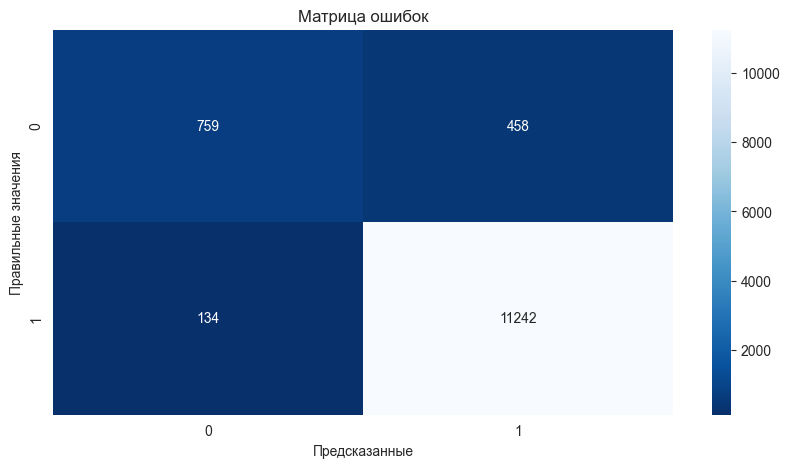

In [49]:
threshold = 0.55

y_pred_threshold = (y_proba[:, 1] >= threshold).astype(int)
valid_results = f1_score(y_valid, y_pred_threshold)

print(f'Лучший показатель метрики F1-score: {valid_results:.5f}')
print()
confusion = confusion_matrix(y_valid, y_pred_threshold)
plt.figure(figsize=(10, 5))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок')
plt.ylabel('Правильные значения')
plt.xlabel('Предсказанные')
plt.show()

**Вывод:**  

При F1-score равном 0.974 модель предсказала следующее:  

- TP = 11242, это значит, что модель 11242 раза верно предсказала продолжение работы стартапов.
- FP = 458, модель 458 раз неверно предсказала закрытие стартапов.
- TN = 759, в данном случае модель 759 раз верно предсказала закрытие стартапов.
- FN = 134, модель 134 раза ошиблась, предсказав закрытие стартапов, которые не закрылись.

### Оценим важность признаков

PermutationExplainer explainer: 12594it [05:57, 35.19it/s]                                                             


<Axes: xlabel='SHAP value (impact on model output)'>

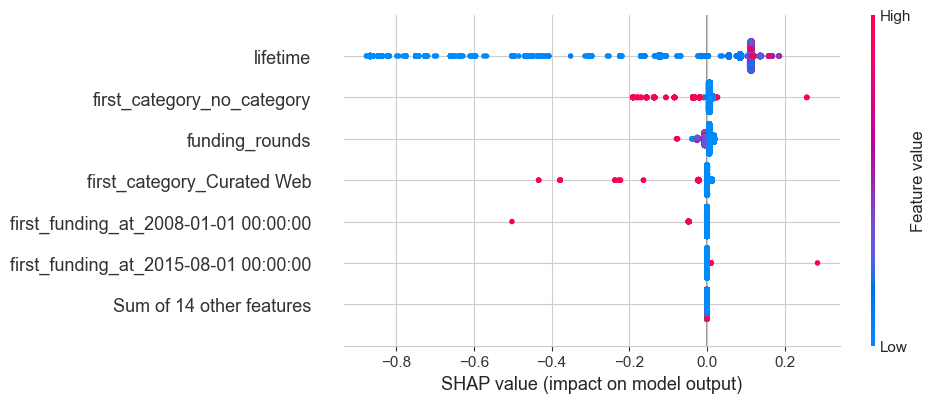

In [50]:
explainer = shap.Explainer(model_dtr.predict_proba, X_valid_selected)
shap_values = explainer(X_valid_selected)

k_best = 7
shap.plots.beeswarm(shap_values[:, :, 1], max_display=k_best, show=False)

**Вывод:**  

На удивление график shap выглядит непривычно странно. Признак **lifetime** имеет небольшое смещение вправо, возможно из-за высокого влияния на целевой признак **status**. Если же убрать признак **lifetime**, то показатели метрики f1-score и качество предсказаний на confusion matrix снижаются, а по графику shap видно, что признак **lifetime** пытаются замещать производные от него - **lifetime_category**. Так что лучше оставить так, как есть, поскольку модель вполне не плохо делает предсказания и не вызывает особых сомнений.

### Предсказания на тестовом датасете

In [57]:
X_test = df_test.drop([
    'name',
    'category_list',
    'country_code',
    'state_code',
    'region',
    'city'
], axis=1)
y = df_train['status']

X_test_prep = data_preprocessor.transform(X_test)

ohe_name = data_preprocessor.named_transformers_['ohe'].get_feature_names_out(cat_col_names)
all_column = ohe_name.tolist() + num_col_names

X_test_prep = pd.DataFrame(X_test_prep, columns=all_column)
X_test_selected = X_test_prep[list(feature_names)]

y_test = model_dtr.predict(X_test_selected)

predict_results = pd.DataFrame({
    'name': df_test['name'],
    'status': ['operating' if x == 1 else 'closed' for x in y_test]
})
print('Предсказания на тестовом датасете:')
display(predict_results.head(10))

C:\Users\pavli\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Предсказания на тестовом датасете:


,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
5,Quickfire Games,operating
6,Sente Inc.,operating
7,Triosyn,operating
8,Urgent.ly,operating
9,Map Decisions,operating


In [59]:
predict_results['status'].value_counts()

status
operating    12336
closed         789
Name: count, dtype: int64

# 10. Итоговый вывод по исследованию

1. **Заказчик предоставил данные о стартапах, работавших в период с 1970 по 2018 годы и попросил выполнить следующие задачи:**  
- Разработать модель машинного обучения для предсказания продолжения деятельности стартапа.  
- Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).

Заказчик предоставил данные в двух файлах: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'  

2. **Предобработка данных:**
- Исрпавлены типы данных.  
- Наименования столбцов не нуждались в исправлениях.  
- Были найдены пропуски и заполнены.  
- Явных дубликатов не было найдено.  
- Были добавлены новые признаки **lifetime_category** и **first_category**.  
  
3. **Исследовательский анализ:**
- В ходе анализа были выявлены аномальные значения и по итогу удалены. Процент удаленных данных не составил более 5%.
- Так же проведен корреляционный анализ данных.  

**Было выявлено следующее:**  
- Целевой признак status имеет дисбаланс, примерно 90%-operating и 10%-closed.  
- Так же на графике с funding_total_usd было заметно смещение вызванное выбросами.  
- Больше всего стартапов с кодом страны USA(30тыс.).  
- Примерно у 5тыс. стартапов не указан код страны.  
- Чуть больше 10тыс. стартапов имеют state_code - CA.  
- Почти 7тыс. стартапов без state_code.  
- 7тыс. стартапов находятся в регионе SF Bay Area.  
- Для 6.4тыс. стартапов не указан регион.  
- Для более чем 6тыс. стартапов не указан город.  
- 3тыс. стартапов в San Francisco.  
- Между целевым признаком status и признаком lifetime присутствует мультиколлинеарность.  
- Признак lifetime коррелирует с признаками country_code(0.97), lifetime_category(1.00) и first_category(0.93.  
- Признак country_code коррелирует с признаком first_category(0.83).  
- Закрытые стартапы зачастую имеют низкое количество дней(lifetime).

4. **Далее была проведена подготовка данных с использованием пайплайнов и кодирование целевого признака "status" с помощью LabelEncoder.**

5. **В ходе обучения были взяты 3 модели машинного обучения:**
- LogisticRegression
- DecisionTreeClassifier
- KNN

Для подбора гиперпараметров мы использовали OptunaSearchCV. Лучше моделью оказалась DecisionTreeClassifier с показателем метрики F1-score - 0.972. Было найдено оптимальное количество признаков для наилучшего качества метрики - 7 признаков. Так же найден подходящий порог классификации - 0.55.  

**При F1-score равном 0.974 модель предсказала следующее:**  
  
- **TP** = 11242, это значит, что модель 11242 раза верно предсказала продолжение работы стартапов.  
- **FP** = 458, модель 458 раз неверно предсказала закрытие стартапов.  
- **TN** = 759, в данном случае модель 759 раз верно предсказала закрытие стартапов.  
- **FN** = 134, модель 134 раза ошиблась, предсказав закрытие стартапов, которые не закрылись.

6. **По итогам проведенной работы можно сделать следующие выводы:**
- В данных присутствуют данные о стартапах преимущественно из северной америки и западной европы. В данном случае там наиболее высокаа конкуренция, но так же и шансы на успех выше.
- В большинстве стартапов главными категориями являются биотехнология, програмное обеспечение, реклама и электронная коммерция.
- В среднем закрывшиеся стартапы работали около 3-х лет, так что для успеха стартапу необходимо преодолеть данный барьер.